In [1]:
import pandas as pd

st = pd.read_csv('./dataset/stress_in_sleep.csv')
st

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0
...,...,...,...,...,...,...,...,...,...
625,69.600,20.960,92.960,10.960,90.960,89.80,3.440,62.40,2
626,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44,0
627,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76,4
628,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32,1


In [2]:
from sklearn.preprocessing import StandardScaler

features = st.iloc[:, :-1]

std = StandardScaler()
std_features = std.fit_transform(features)
std_under_h_df = pd.DataFrame(std_features, columns=features.columns)

for column in std_under_h_df.columns:
    std_under_h_df.drop(
        std_under_h_df[~std_under_h_df[column].between(-1.96, 1.96)].index, 
        axis=0, 
        inplace=True)

for column in std_under_h_df.columns:
    print(f'{column}: {std_under_h_df[~std_under_h_df[column].between(-1.96, 1.96)].shape[0]}건')
    


sr: 0건
rr: 0건
t: 0건
lm: 0건
bo: 0건
rem: 0건
sr.1: 0건
hr: 0건


In [3]:
st = st.iloc[std_under_h_df.index].reset_index(drop=True)
st

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0
...,...,...,...,...,...,...,...,...,...
551,69.600,20.960,92.960,10.960,90.960,89.80,3.440,62.40,2
552,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44,0
553,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76,4
554,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32,1


In [41]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
parameters = {
    'max_depth': [1],
    'min_samples_split': [20,25,30,35]
}

rfc = RandomForestClassifier(n_estimators=10)

features, targets = st.iloc[:, :-1], st.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

smote = SMOTE(random_state=124)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

g_rfc = GridSearchCV(rfc, param_grid=parameters, cv=10, n_jobs=-1)

g_rfc.fit(X_train_over, y_train_over)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_estimators=10),
             n_jobs=-1,
             param_grid={'max_depth': [1],
                         'min_samples_split': [20, 25, 30, 35]})

In [42]:
result_df = pd.DataFrame(g_rfc.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 1, 'min_samples_split': 20}",0.869725,4
1,"{'max_depth': 1, 'min_samples_split': 25}",0.952471,1
2,"{'max_depth': 1, 'min_samples_split': 30}",0.894863,3
3,"{'max_depth': 1, 'min_samples_split': 35}",0.913686,2


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction, average='macro')
    recall = recall_score(y_test , prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [43]:
rfc = g_rfc.best_estimator_
prediction = rfc.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


오차 행렬
[[ 0 19  0  0  0]
 [ 0 25  0  0  0]
 [ 0  1 23  1  0]
 [ 0  0  0 26  0]
 [ 0  0  0  0 17]]
정확도: 0.8125, 정밀도: 0.7037, 재현율: 0.7840, F1: 0.7308
################################################################################


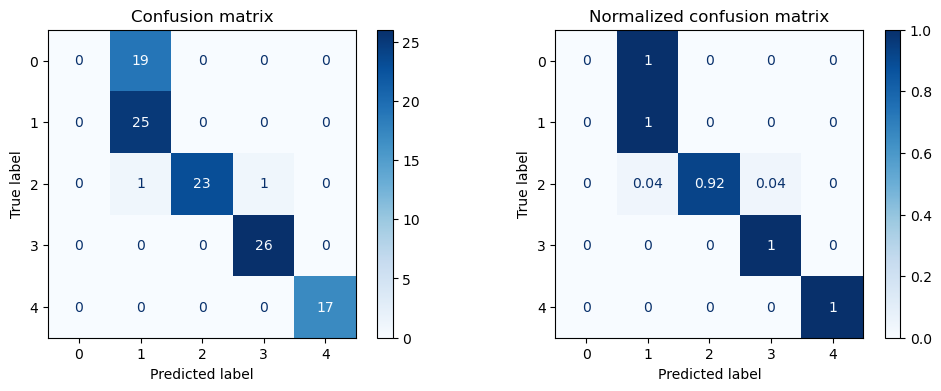

In [44]:
get_evaluation(y_test, prediction, rfc, X_test)

In [ ]:
# n_estimators 최대한 낮추고  max_depth, min_samples_split 요것들도 최대로 낮은것들 해봐도 .99나옴.. 

In [ ]:
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE
# parameters = {
#     'max_depth': [1],
#     'min_samples_split': [20,25,30,35]
# }

# rfc = RandomForestClassifier(n_estimators=10)

# features, targets = st.iloc[:, :-1], st.iloc[:, -1]

# X_train, X_test, y_train, y_test = \
# train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

# smote = SMOTE(random_state=124)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# g_rfc = GridSearchCV(rfc, param_grid=parameters, cv=10, n_jobs=-1)

# g_rfc.fit(X_train_over, y_train_over)

# 이정도로 망가져야

# 오차 행렬
# [[ 0 19  0  0  0]
#  [ 0 25  0  0  0]
#  [ 0  1 23  1  0]
#  [ 0  0  0 26  0]
#  [ 0  0  0  0 17]]
# 정확도: 0.8125, 정밀도: 0.7037, 재현율: 0.7840, F1: 0.7308
# ################################################################################
# 연관도 높은걸 없앨수는...

In [45]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(rfc, X_test, y_test, n_repeats=30, random_state=124)
importance.importances_mean.argsort()[::-1]

array([7, 6, 5, 4, 3, 2, 1, 0], dtype=int64)

In [46]:
for i in importance.importances_mean.argsort()[::-1]:
    print(f'{features.columns[i]}: {round(importance.importances_mean[i], 4)}')

hr: 0.0
sr.1: 0.0
rem: 0.0
bo: 0.0
lm: 0.0
t: 0.0
rr: 0.0
sr: 0.0
